Load required packages: 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from os import listdir
from scipy import stats
from sklearn.metrics import pairwise_distances, r2_score

from functions import calc_D0, calc_D1, calc_D2
from functions import get_insilico_df
from functions import get_gmm_fitted, get_fcfp_gmm
from functions import get_binning_grid, get_fcfp_binning_grid
from functions import get_KFold, get_trained_RF
from functions import mantel_test
from functions import transform        

Initialize metavariables: 

In [2]:
''' Metavariables '''
np.random.seed(np.int(2703))
PATH_DATA = '../Data/Individual_Populations/'
FILENAMES = listdir(PATH_DATA)
MIN_SAMPLES_LEAF = 5 
N_ITER = 10 #this value is 100 for the results in the paper
N_REP = 2
S = 20

A = 1
FEATURES = ['FL1-H','SSC-H','FSC-H']#'FL2-H','FL3-H','FL4-H'][0:3]
N_CELLS_REP_c = 2500
N_CELLS_REP_i = 2500
N_MIX = 128
N_SAMPLES = 300
N_TREES = 200
TYPE = 'full'#['full','tied','diag','spherical'][0]

Load in simulated microbial community compositions: 

In [3]:
comp_train = pd.read_csv('../Files/Comp_train_a='+str(A)+'.csv', index_col=0, header=0) 
comp_test = pd.read_csv('../Files/Comp_test_a='+str(A)+'.csv', index_col=0, header=0) 

Determine $\alpha$-diversity values: 

In [4]:
d0_train = calc_D0(comp_train)   
d1_train = calc_D1(comp_train)
d2_train = calc_D2(comp_train)

d0_test = calc_D0(comp_test)   
d1_test = calc_D1(comp_test)
d2_test = calc_D2(comp_test)

Determine $\beta$-diversity values: 

In [5]:
bc_train_comp = pd.DataFrame(pairwise_distances(comp_train, metric='braycurtis'), index=comp_train.index, columns=comp_train.index)
bc_test_comp = pd.DataFrame(pairwise_distances(comp_test, metric='braycurtis'), index=comp_test.index, columns=comp_test.index)

Create _in silico_ microbial communities by sampling flow cytometry data according to the proportions in `comp_train` and `comp_test`:

(note: this takes quite some time)

In [6]:
df_train = get_insilico_df(PATH_DATA,FILENAMES,comp_train,N_CELLS_REP_c,N_REP)
df_test = get_insilico_df(PATH_DATA,FILENAMES,comp_test,N_CELLS_REP_c,N_REP)

Transform the data by $f(x) = \text{asinh}(x)$: 

In [7]:
df_train_trans = transform(df_train,FEATURES)
df_test_trans = transform(df_test,FEATURES)

Fit a Gaussian Mixture Model to the data: 

In [8]:
gmm = get_gmm_fitted(df_train_trans, FEATURES, N_MIX, TYPE, transform_bool=False)

Retrieve fingerprints per sample using the fitted GMM and store them in one dataframe: 

In [9]:
fcfp_train_gmm = get_fcfp_gmm(PATH_DATA,FILENAMES,comp_train,FEATURES,gmm,N_CELLS_REP_i,N_REP,N_MIX,True)
fcfp_test_gmm = get_fcfp_gmm(PATH_DATA,FILENAMES,comp_test,FEATURES,gmm,N_CELLS_REP_i,N_REP,N_MIX,True) 

Fit a grid to each bivariate combination of the channels: 

In [10]:
grids = get_binning_grid(df_train_trans,FEATURES,N_MIX,False,False)

Retrieve fingerprints per sample using this collection of grids, vectorize the cell counts, and store them in one dataframe: 

In [11]:
fcfp_train_grid = get_fcfp_binning_grid(PATH_DATA,FILENAMES,comp_train,FEATURES,grids,N_CELLS_REP_i,N_REP,False,True)
fcfp_test_grid = get_fcfp_binning_grid(PATH_DATA,FILENAMES,comp_test,FEATURES,grids,N_CELLS_REP_i,N_REP,False,True) 

Perform rapid $\alpha$-diversity estimations, by applying the Hill-diversity formulas directly to the fingerprint data: 

In [12]:
D0_test_fcfp_gmm = calc_D0(fcfp_test_gmm)
D1_test_fcfp_gmm = calc_D1(fcfp_test_gmm)
D2_test_fcfp_gmm = calc_D2(fcfp_test_gmm)
    
D0_test_fcfp_grid = calc_D0(fcfp_test_grid)
D1_test_fcfp_grid = calc_D1(fcfp_test_grid)
D2_test_fcfp_grid = calc_D2(fcfp_test_grid)

Calculate Kendall's $\tau_B$ between cytometric and true $\alpha$-diversity: 

In [13]:
k_uns_test_d0_gmm, p_k_uns_test_d0_gmm = stats.kendalltau(D0_test_fcfp_gmm,d0_test)
k_uns_test_d1_gmm, p_k_uns_test_d1_gmm = stats.kendalltau(D1_test_fcfp_gmm,d1_test)
k_uns_test_d2_gmm, p_k_uns_test_d2_gmm = stats.kendalltau(D2_test_fcfp_gmm,d2_test)

k_uns_test_d0_grid, p_k_uns_test_d0_grid = stats.kendalltau(D0_test_fcfp_grid,d0_test)
k_uns_test_d1_grid, p_k_uns_test_d1_grid = stats.kendalltau(D1_test_fcfp_grid,d1_test)
k_uns_test_d2_grid, p_k_uns_test_d2_grid = stats.kendalltau(D2_test_fcfp_grid,d2_test)

Values for $D_1$: 

In [14]:
print('Kendall tau_B for PhenoGMM:' + str(k_uns_test_d1_gmm))
print('P-value:' + str(p_k_uns_test_d1_gmm))

print('Kendall tau_B for PhenoGrid:' + str(k_uns_test_d1_grid))
print('P-value::' + str(p_k_uns_test_d1_grid))

Kendall tau_B for PhenoGMM:0.431515151515
P-value:2.00108699414e-10
Kendall tau_B for PhenoGrid:0.146666666667
P-value::0.0306094835826


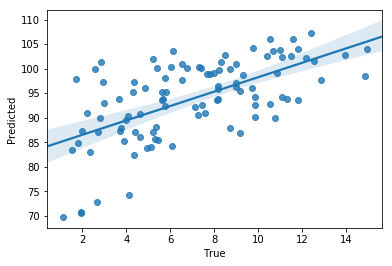

In [16]:
d1_gmm = pd.DataFrame({'True':d1_test.iloc[:,0],'Predicted': D1_test_fcfp_gmm.iloc[:,0]}, index=d1_test.index)
sns.regplot(x='True', y='Predicted', data=d1_gmm)

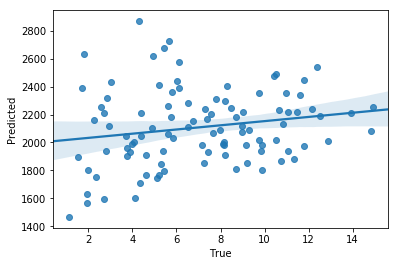

In [17]:
d1_grid = pd.DataFrame({'True':d1_test.iloc[:,0],'Predicted': D1_test_fcfp_grid.iloc[:,0]}, index=d1_test.index)
sns.regplot(x='True', y='Predicted', data=d1_grid)

Calculate the $\beta$-diversity between samples using the Bray-Curtis dissimilarity and correlate it with the true compositions using the mantel test: 

In [18]:
bc_test_fcfp_gmm = pd.DataFrame(pairwise_distances(fcfp_test_gmm, metric='braycurtis'), index=fcfp_test_gmm.index, columns=fcfp_test_gmm.index)
bc_test_fcfp_grid = pd.DataFrame(pairwise_distances(fcfp_test_grid, metric='braycurtis'), index=fcfp_test_grid.index, columns=fcfp_test_grid.index)

mantel_beta_div_test_gmm, p_mantel_beta_div_test_gmm = mantel_test(bc_test_comp, bc_test_fcfp_gmm)
mantel_beta_div_test_grid, p_mantel_beta_div_test_grid = mantel_test(bc_test_comp, bc_test_fcfp_grid)

print('Mantel correlation between PhenoGMM and True Beta-diversities:' + str(mantel_beta_div_test_gmm))
print('Mantel correlation between PhenoGrid and True Beta-diversities:' + str(mantel_beta_div_test_grid))

Mantel correlation between PhenoGMM and True Beta-diversities:0.61879590807
Mantel correlation between PhenoGrid and True Beta-diversities:0.515408023232


Predict $D_1$ using Random Forest regression based on the cytometric fingerprints: 

In [19]:
kcv = get_KFold(5)
rf_gmm = get_trained_RF(fcfp_train_gmm, d1_train.values.ravel(), fcfp_train_gmm.columns, N_TREES, MIN_SAMPLES_LEAF, N_ITER, kcv)
preds_test_gmm = rf_gmm.predict(fcfp_test_gmm)
r2_test_d1_gmm = r2_score(d1_test,preds_test_gmm)
k_test_d1_gmm, p_k_test_d1_gmm = stats.kendalltau(d1_test,preds_test_gmm)

print('R² for supervised estimations using PhenoGMM: ' + str(r2_test_d1_gmm))
print('Kendall tau_B for supervised estimations using PhenoGMM: ' + str(k_test_d1_gmm))
print('P-value: ' + str(p_k_test_d1_gmm))

R² for supervised estimations using PhenoGMM: 0.600501537708
Kendall tau_B for supervised estimations using PhenoGMM: 0.608080808081
P-value: 3.12735552223e-19


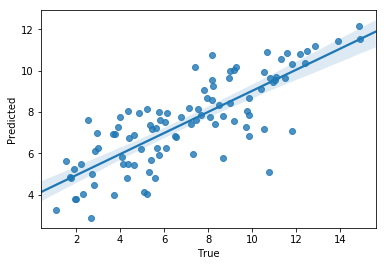

In [20]:
pred_gmm = pd.DataFrame({'True':d1_test.iloc[:,0],'Predicted': preds_test_gmm}, index=d1_test.index)
sns.regplot(x='True', y='Predicted', data=pred_gmm)

In [21]:
rf_grid = get_trained_RF(fcfp_train_grid, d1_train.values.ravel(), fcfp_train_grid.columns, N_TREES, MIN_SAMPLES_LEAF, N_ITER, kcv)
preds_test_grid = rf_grid.predict(fcfp_test_grid)
r2_test_d1_grid = r2_score(d1_test,preds_test_grid)
k_test_d1_grid, p_k_test_d1_grid = stats.kendalltau(d1_test,preds_test_grid)

print('R² for supervised estimations using PhenoGrid: ' + str(r2_test_d1_grid))
print('Kendall tau_B for supervised estimations using PhenoGrid: ' + str(k_test_d1_grid))
print('P-value: ' + str(p_k_test_d1_grid))

R² for supervised estimations using PhenoGrid: 0.56420908496
Kendall tau_B for supervised estimations using PhenoGrid: 0.659797979798
P-value: 2.32386495064e-22


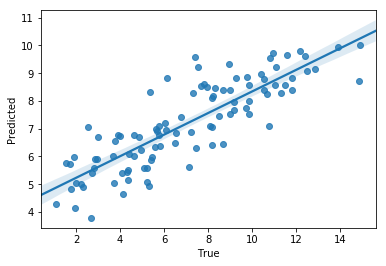

In [22]:
pred_grid = pd.DataFrame({'True':d1_test.iloc[:,0],'Predicted': preds_test_grid}, index=d1_test.index)
sns.regplot(x='True', y='Predicted', data=pred_grid)